### Performing Feature Extraction 

In [ ]:
import os
import essentia.standard as ess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

# Configuration
BASE_DIR = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_DIR = BASE_DIR / 'data'
PROCESSED_DATA_DIR = DATA_DIR / 'processed' / 'birdcall_segments_5s_113'
METADATA_PATH = DATA_DIR / 'processed' / 'birdcall_metadata_113.csv'
FEATURES_DIR = DATA_DIR / 'features'
FEATURES_DIR.mkdir(parents=True, exist_ok=True)

def load_metadata():
    """Load and validate metadata CSV"""
    metadata = pd.read_csv(METADATA_PATH)
    
    # Validate required columns
    required_cols = {'filename', 'species', 'call_type'}
    if not required_cols.issubset(metadata.columns):
        missing = required_cols - set(metadata.columns)
        raise ValueError(f"Metadata missing required columns: {missing}")
    
    # Create full paths and verify files exist
    metadata['full_path'] = metadata['filename'].apply(
        lambda x: str(PROCESSED_DATA_DIR / x)
    )
    
    # Check which files actually exist
    metadata['file_exists'] = metadata['full_path'].apply(
        lambda x: Path(x).exists()
    )
    
    existing_files = metadata[metadata['file_exists']]
    if len(existing_files) == 0:
        raise FileNotFoundError("No audio files found matching metadata records")
    
    print(f"Loaded metadata for {len(metadata)} records")
    print(f"Found {len(existing_files)} matching audio files")
    
    return existing_files[['full_path', 'species', 'call_type']].to_dict('records')

def initialize_extractor():
    """Configure audio feature extractor with optimal settings"""
    return ess.FreesoundExtractor(
        lowlevelStats=["mean", "stdev"],
        tonalStats=["mean", "stdev"],
        mfccStats=["mean", "stdev"],
        gfccStats=["mean", "stdev"],
        lowlevelFrameSize=2048,  # Smaller window for bird calls
        lowlevelHopSize=1024,
        lowlevelSilentFrames="drop"
    )

def extract_features(audio_files, output_csv):
    """Batch feature extraction with progress tracking"""
    extractor = initialize_extractor()
    features_data = []
    failed_files = []
    
    # Get feature names from first successful file
    sample_features = None
    for file in audio_files[:5]:  # Try first 5 files
        try:
            features, _ = extractor(file['full_path'])
            sample_features = features
            break
        except Exception:
            continue
    
    if sample_features is None:
        raise RuntimeError("Could not extract features from any sample file")
    
    # Select only numeric features (skip arrays)
    feature_names = sorted([
        desc for desc in sample_features.descriptorNames()
        if isinstance(sample_features[desc], (float, int)) and 
        any(x in desc for x in ["lowlevel", "mfcc", "gfcc", "tonal"])
    ])
    
    # Batch processing with error handling
    for file in tqdm(audio_files, desc="Extracting features"):
        try:
            features, _ = extractor(file['full_path'])
            row = {name: features[name] for name in feature_names}
            row.update({
                'species': file['species'],
                'call_type': file['call_type'],
                'filename': Path(file['full_path']).name
            })
            features_data.append(row)
        except Exception as e:
            failed_files.append((file['full_path'], str(e)))
    
    # Error reporting
    if failed_files:
        print(f"\nFailed to process {len(failed_files)} files ({(len(failed_files)/len(audio_files)*100):.1f}%)")
        for path, error in failed_files[:3]:
            print(f"- {Path(path).name}: {error}")
    
    # Create and save dataframe
    features_df = pd.DataFrame(features_data)
    
    # Versioned output
    version = 1
    while output_csv.exists():
        output_csv = output_csv.parent / f"{output_csv.stem}_v{version}{output_csv.suffix}"
        version += 1
    
    features_df.to_csv(output_csv, index=False)
    return features_df


def main():
    print("🚀 Starting Bird Call Feature Extraction Pipeline")
    
    try:
        # 1. Load and validate data
        print("\n🔍 Loading metadata and audio files...")
        audio_files = load_metadata()
        
        # 2. Feature extraction
        print("\n⚙️ Extracting audio features...")
        features_csv = FEATURES_DIR / 'birdcall_features_113.csv'
        features_df = extract_features(audio_files, features_csv)
        print(f"✅ Extracted {len(features_df.columns)-3} features from {len(features_df)} files")
        
        print(f"\n🎉 Pipeline completed! Features saved to:\n{features_csv}")
        
    except Exception as e:
        print(f"\n❌ Pipeline failed: {str(e)}")

if __name__ == "__main__":
    main()

### TOP 50 BIRD SELECTION (THE USER COULD SELECT THE SUBSET THEY WANT TO TRAIN WITH)

In [ ]:
import os
import shutil
import pandas as pd
from pathlib import Path

# Configuration
BASE_DIR = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_DIR = BASE_DIR / 'data'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'

# Original folders and files
ORIGINAL_SEGMENTS_DIR = PROCESSED_DATA_DIR / 'birdcall_segments_5s_113'
ORIGINAL_METADATA = PROCESSED_DATA_DIR / 'birdcall_metadata_113.csv'

# New folders for top 50
TOP50_SEGMENTS_DIR = PROCESSED_DATA_DIR / 'birdcall_segments_5s_TOP50'
TOP50_METADATA = PROCESSED_DATA_DIR / 'birdcall_metadata_TOP50.csv'

# List of top 50 bird species (from your ranking) with both naming formats
TOP50_SPECIES = {
    # Format: "Display Name": ["csv_name", "filename_prefix"]
    "Curve-billed Tinamou": ["curve-billed_tinamou", "curve-billed_tinamou"],
    "Tongan Megapode": ["tongan_megapode", "tongan_megapode"],
    "Micronesian Megapode": ["micronesian_megapode", "micronesian_megapode"],
    "Elegant Crested Tinamou": ["elegant_crested_tinamou", "elegant_crested_tinamou"],
    "Tepui Tinamou": ["tepui_tinamou", "tepui_tinamou"],
    "Cinereous Tinamou": ["cinereous_tinamou", "cinereous_tinamou"],
    "Lesser Nothura": ["lesser_nothura", "lesser_nothura"],
    "Puna Tinamou": ["puna_tinamou", "puna_tinamou"],
    "Lesser Rhea": ["lesser_rhea", "lesser_rhea"],
    "Barred Tinamou": ["barred_tinamou", "barred_tinamou"],
    "Dwarf Tinamou": ["dwarf_tinamou", "dwarf_tinamou"],
    "Little Spotted Kiwi": ["little_spotted_kiwi", "little_spotted_kiwi"],
    "Sula Megapode": ["sula_megapode", "sula_megapode"],
    "Vanuatu Megapode": ["vanuatu_megapode", "vanuatu_megapode"],
    "Baudo Guan": ["baudo_guan", "baudo_guan"],
    "Undulated Tinamou": ["undulated_tinamou", "undulated_tinamou"],
    "Biak Scrubfowl": ["biak_scrubfowl", "biak_scrubfowl"],
    "Bartlett's Tinamou": ["bartlett's_tinamou", "bartletts'_tinamou"],
    "Huayco Tinamou": ["huayco_tinamou", "huayco_tinamou"],
    "Wattled Brushturkey": ["wattled_brushturkey", "wattled_brushturkey"],
    "Chestnut-headed Chachalaca": ["chestnut-headed_chachalaca", "chestnut-headed_chachalaca"],
    "Common Ostrich": ["common_ostrich", "common_ostrich"],
    "New Guinea Scrubfowl": ["new_guinea_scrubfowl", "new_guinea_scrubfowl"],
    "Ornate Tinamou": ["ornate_tinamou", "ornate_tinamou"],
    "Trinidad Piping Guan": ["trinidad_piping_guan", "trinidad_piping_guan"],
    "Red-billed Brushturkey": ["red-billed_brushturkey", "red-billed_brushturkey"],
    "Andean Guan": ["andean_guan", "andean_guan"],
    "Quebracho Crested Tinamou": ["quebracho_crested_tinamou", "quebracho_crested_tinamou"],
    "Berlepsch's Tinamou": ["berlepsch's_tinamou", "berlepsch's_tinamou"],
    "White-winged Guan": ["white-winged_guan", "white-winged_guan"],
    "Hooded Tinamou": ["hooded_tinamou", "hooded_tinamou"],
    "Southern Brown Kiwi": ["southern_brown_kiwi", "southern_brown_kiwi"],
    "Great Spotted Kiwi": ["great_spotted_kiwi", "great_spotted_kiwi"],
    "Chilean Tinamou": ["chilean_tinamou", "chilean_tinamou"],
    "Band-tailed Guan": ["band-tailed_guan", "band-tailed_guan"],
    "Highland Tinamou": ["highland_tinamou", "highland_tinamou"],
    "Malleefowl": ["malleefowl", "malleefowl"],
    "Bearded Guan": ["bearded_guan", "bearded_guan"],
    "Brown Tinamou": ["brown_tinamou", "brown_tinamou"],
    "White-bellied Nothura": ["white-bellied_nothura", "white-bellied_nothura"],
    "Spix's Guan": ["spix's_guan", "spix's_guan"],
    "Choco Tinamou": ["choco_tinamou", "choco_tinamou"],
    "Grey-headed Chachalaca": ["grey-headed_chachalaca", "grey-headed_chachalaca"],
    "Black-fronted Piping Guan": ["black-fronted_piping_guan", "black-fronted_piping_guan"],
    "Cauca Guan": ["cauca_guan", "cauca_guan"],
    "Thicket Tinamou": ["thicket_tinamou", "thicket_tinamou"],
    "Great Tinamou": ["great_tinamou", "great_tinamou"],
    "Dusky-legged Guan": ["dusky-legged_guan", "dusky-legged_guan"],
    "Chaco Chachalaca": ["chaco_chachalaca", "chaco_chachalaca"],
    "Black-capped Tinamou": ["black-capped_tinamou", "black-capped_tinamou"]
}

def create_top50_dataset():
    # Create output directory if it doesn't exist
    TOP50_SEGMENTS_DIR.mkdir(parents=True, exist_ok=True)
    
    # Load original metadata
    original_metadata_df = pd.read_csv(ORIGINAL_METADATA)
    
    # Create a mapping from CSV species names to display names
    species_mapping = {v[0]: k for k, v in TOP50_SPECIES.items()}
    
    # Filter metadata for top 50 species
    top50_metadata_df = original_metadata_df[
        original_metadata_df['species'].isin(species_mapping.keys())
    ].copy()
    
    # Map the species names to their display names
    top50_metadata_df['species'] = top50_metadata_df['species'].map(species_mapping)
    
    # Save filtered metadata
    top50_metadata_df.to_csv(TOP50_METADATA, index=False)
    print(f"Saved metadata for {len(top50_metadata_df)} segments to {TOP50_METADATA}")
    
    # Copy corresponding audio files
    copied_files = 0
    for _, row in top50_metadata_df.iterrows():
        src_path = ORIGINAL_SEGMENTS_DIR / row['filename']
        dst_path = TOP50_SEGMENTS_DIR / row['filename']
        
        if src_path.exists():
            shutil.copy2(src_path, dst_path)
            copied_files += 1
        else:
            print(f"Warning: File not found - {src_path}")
    
    print(f"Copied {copied_files} audio files to {TOP50_SEGMENTS_DIR}")
    
    # Verify counts
    unique_species = top50_metadata_df['species'].nunique()
    print(f"\nDataset contains {unique_species} species and {len(top50_metadata_df)} segments")
    print("Top 50 species distribution:")
    print(top50_metadata_df['species'].value_counts().head(10))
    print("...")  # Truncated for brevity

if __name__ == "__main__":
    print("Creating dataset for top 50 performing bird species...")
    create_top50_dataset()
    print("\nDone!")

### FEATURE ENGINEERING VISUALIZATION

🔬 Starting Enhanced Feature Analysis Pipeline

🔍 Running comprehensive feature selection...
  - Mutual Information selection...
  - Recursive Feature Elimination...
  - Random Forest Importance...
  - XGBoost Importance...

✅ Selected top 20 features:
- lowlevel.spectral_energyband_middle_low.stdev
- lowlevel.hfc.stdev
- lowlevel.pitch_salience.stdev
- lowlevel.spectral_centroid.mean
- lowlevel.spectral_energyband_high.stdev
- lowlevel.spectral_complexity.mean
- lowlevel.spectral_decrease.stdev
- lowlevel.spectral_strongpeak.stdev
- lowlevel.spectral_complexity.stdev
- lowlevel.spectral_energyband_middle_low.mean
- lowlevel.spectral_strongpeak.mean
- lowlevel.loudness_ebu128.integrated
- lowlevel.erbbands_skewness.mean
- lowlevel.pitch.mean
- lowlevel.spectral_flux.stdev
- lowlevel.spectral_rolloff.mean
- lowlevel.zerocrossingrate.mean
- lowlevel.silence_rate_60dB.stdev
- lowlevel.spectral_energyband_middle_high.mean
- lowlevel.pitch_salience.mean

📊 Visualizing feature space with PCA.


📊 Visualizing feature space with t-SNE...



📈 Plotting feature importance...


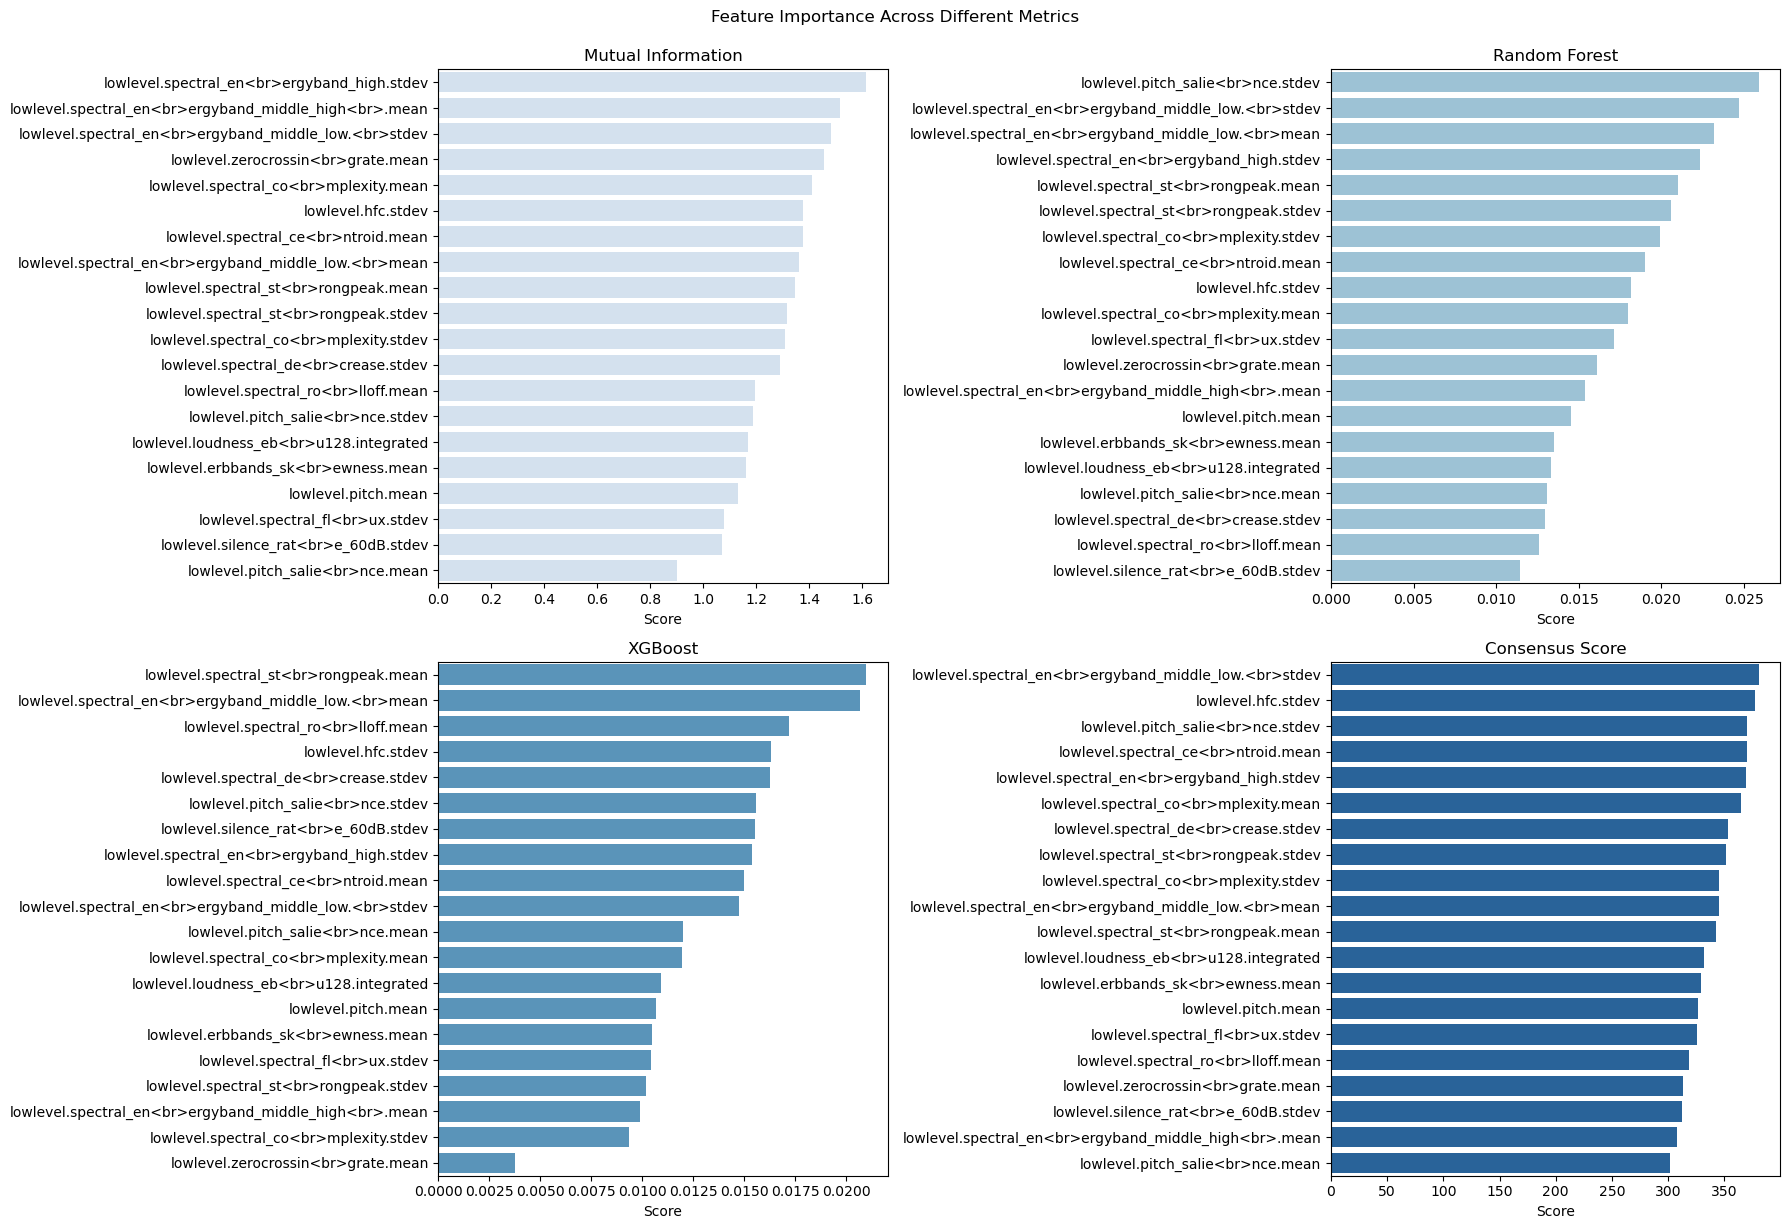


🔥 Plotting feature correlation heatmap...


<Figure size 1600x1400 with 0 Axes>

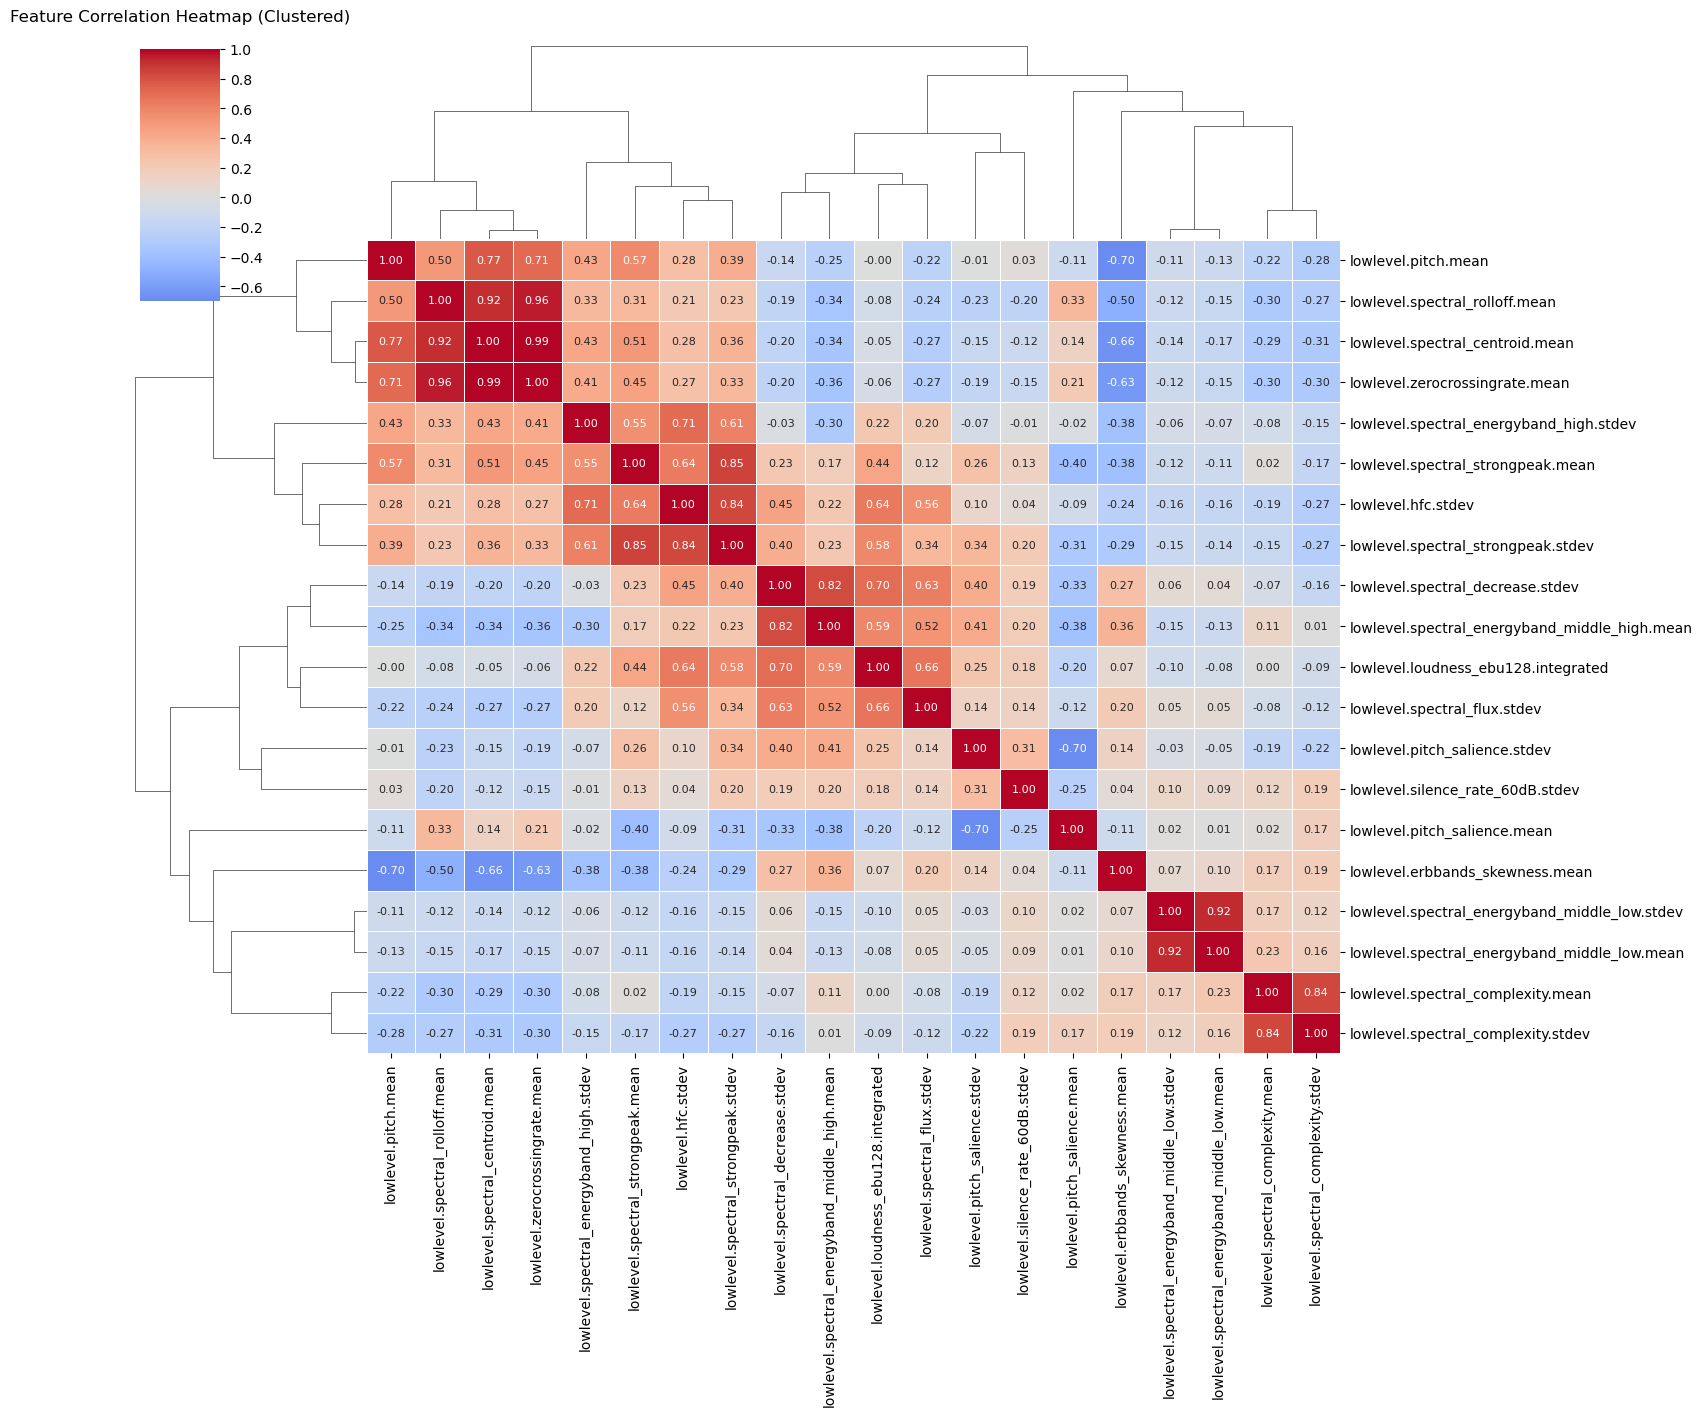


🌳 Plotting feature clustering...


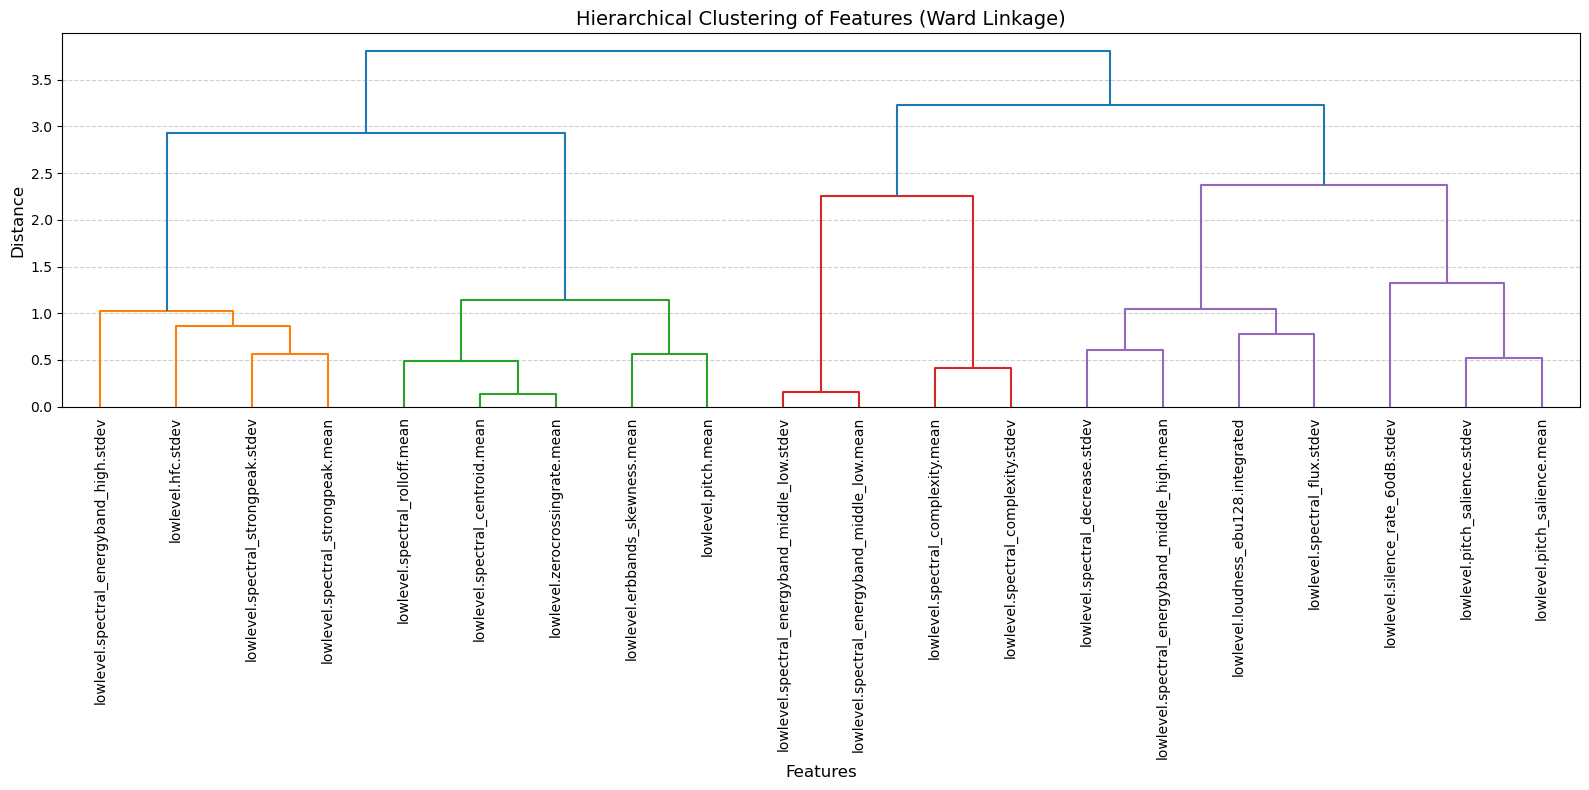


🎻 Plotting feature distributions...


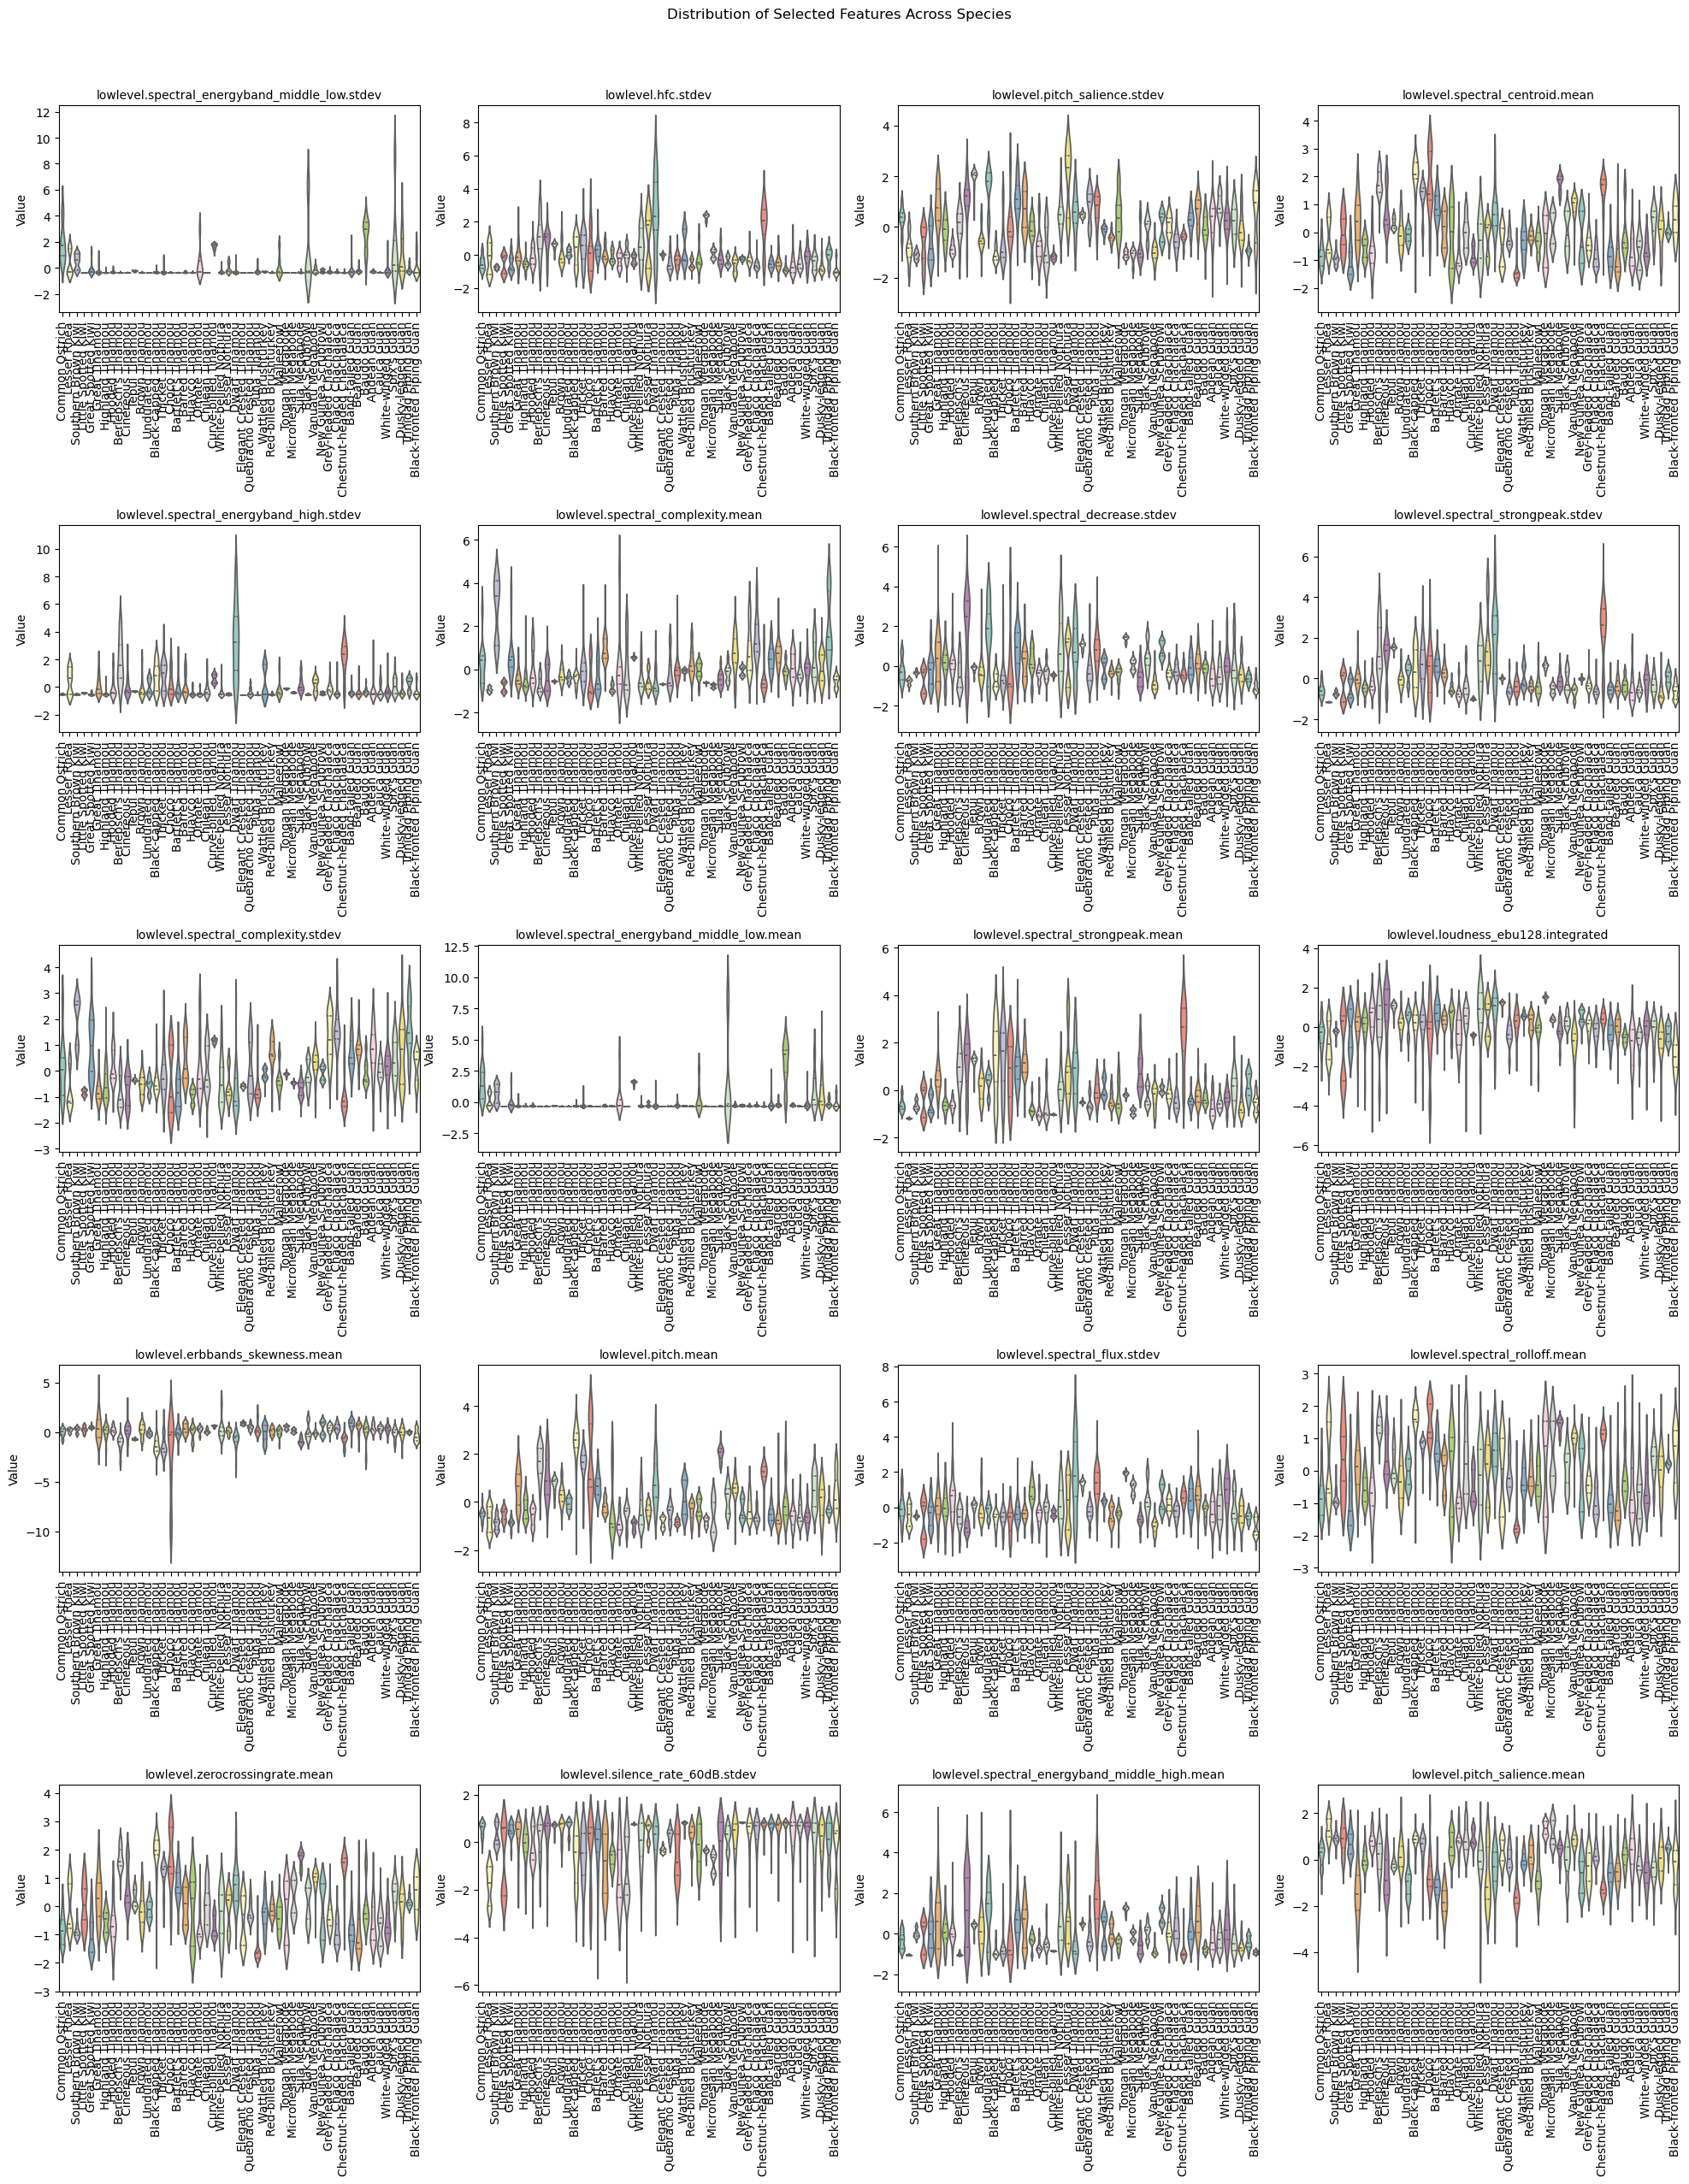


📊 Plotting pairwise relationships of top features...


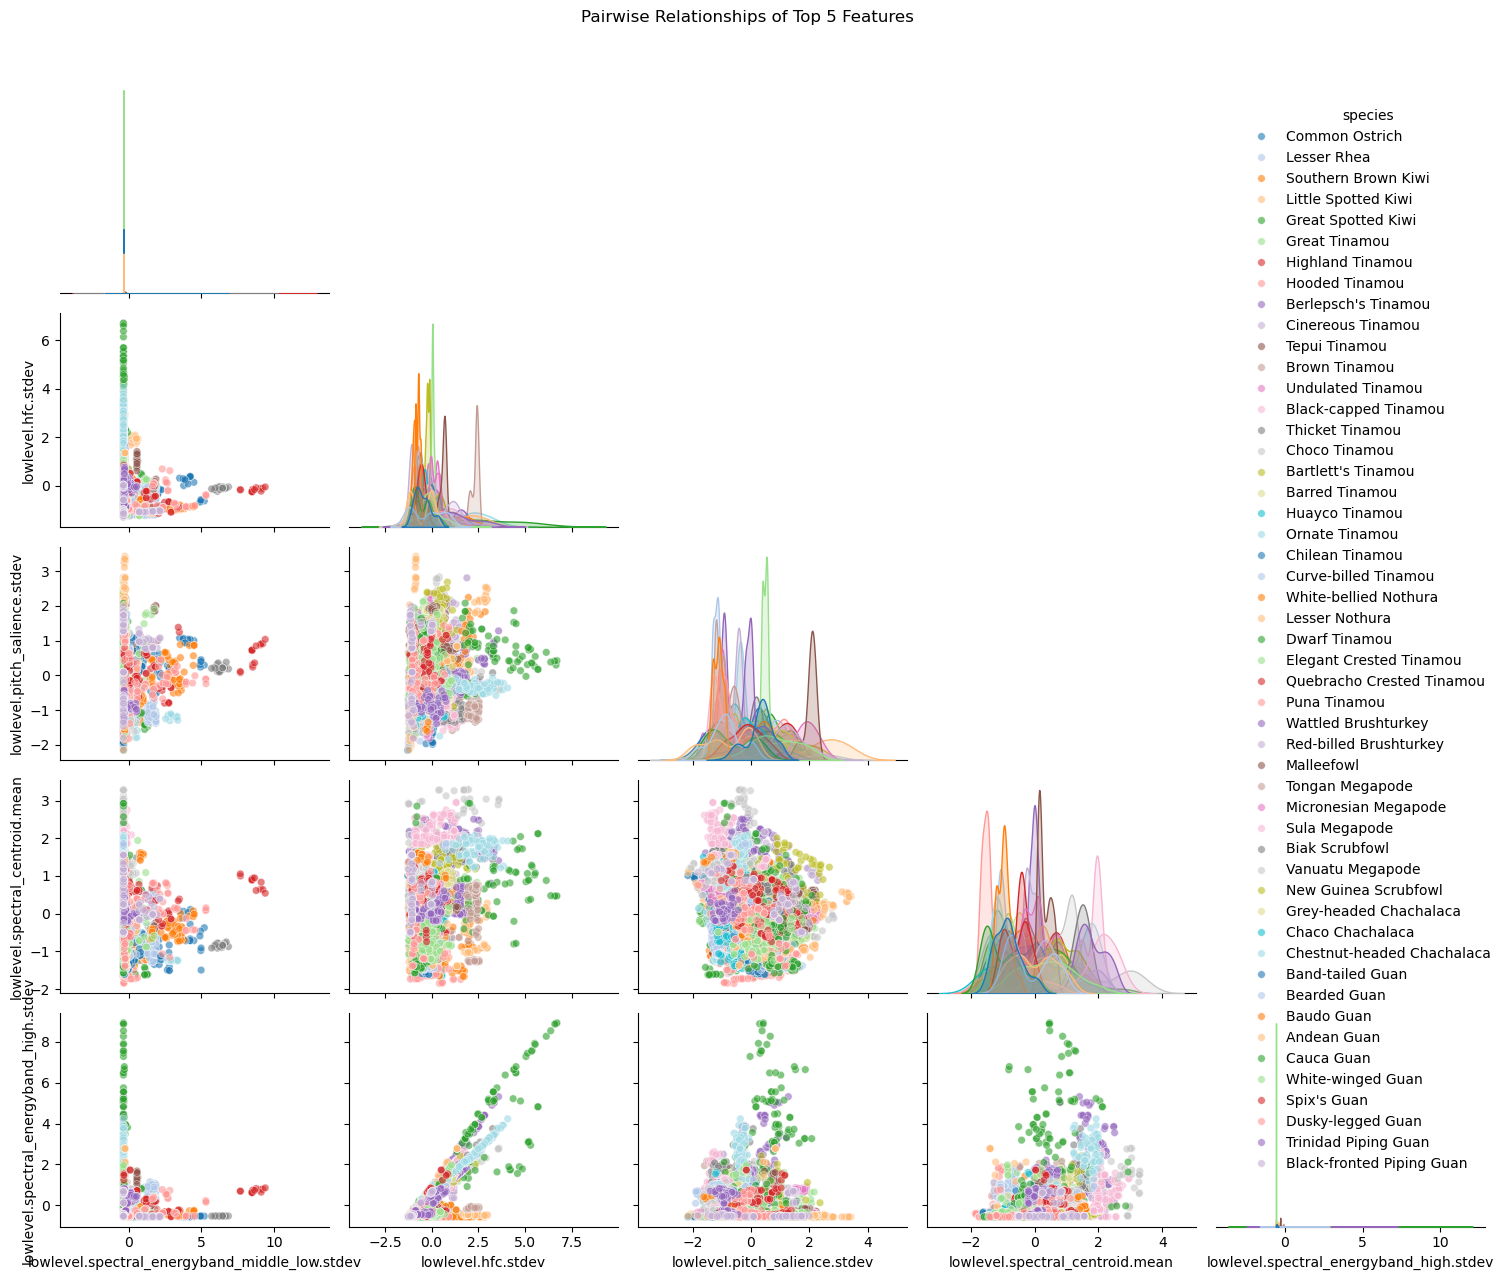


📉 Plotting parallel coordinates...


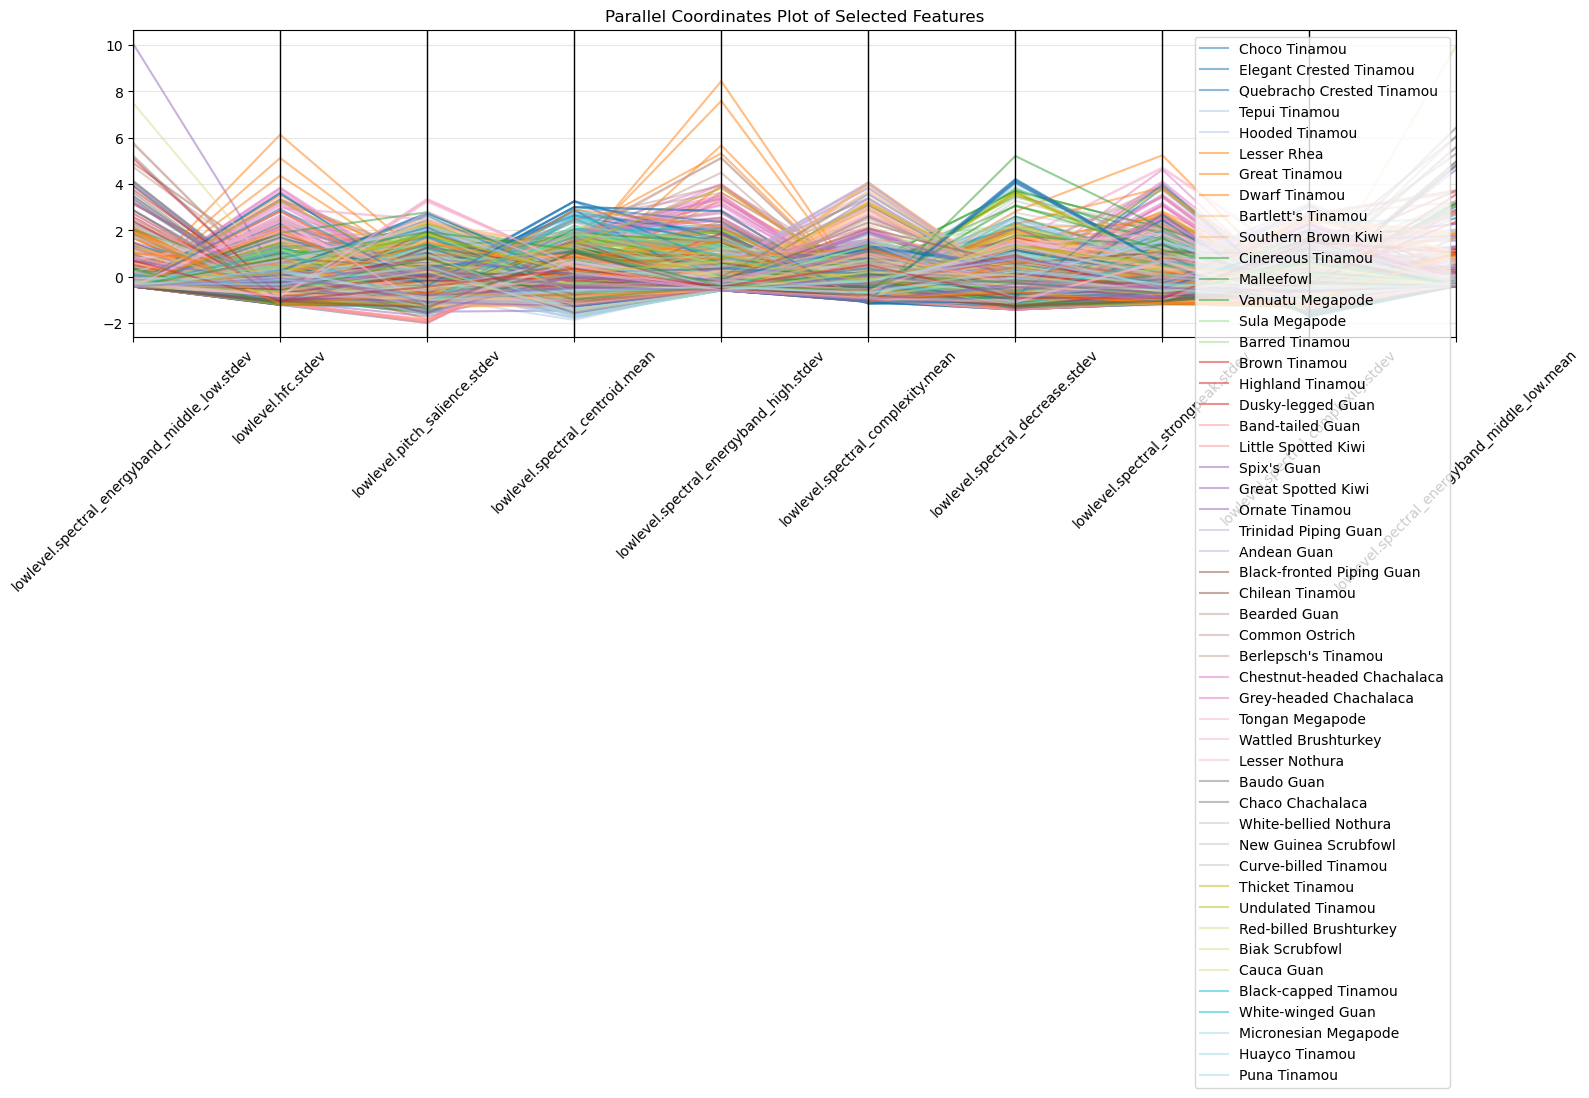


📊 Generating Grouped Dimensionality Reduction Plots...

📊 PCA - Group 1: 10 species


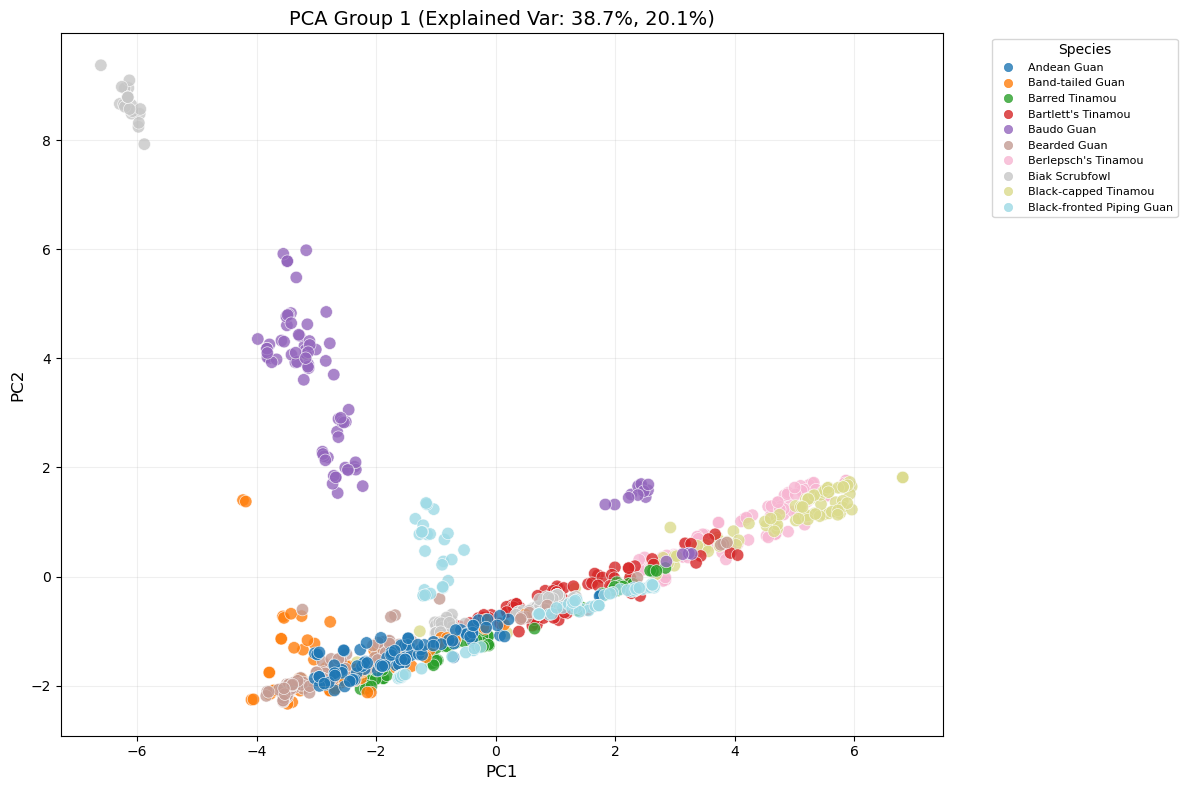


📊 PCA - Group 2: 10 species


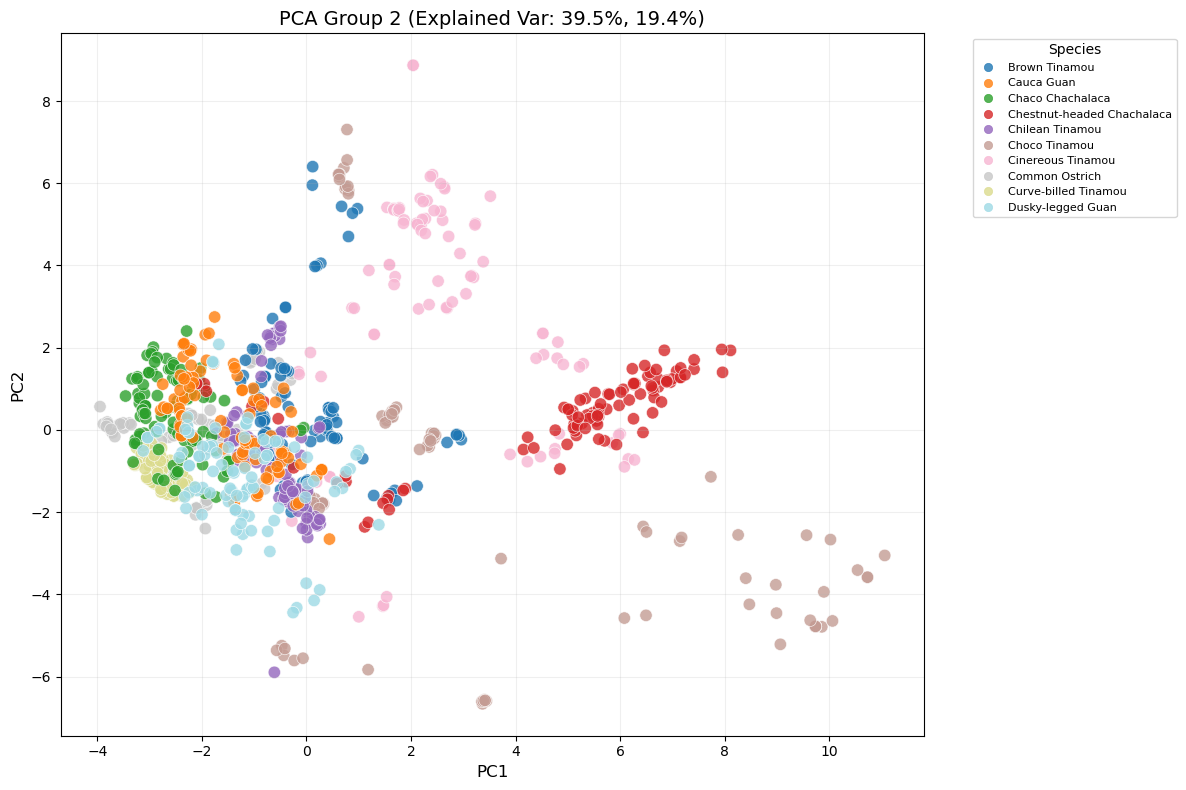


📊 PCA - Group 3: 10 species


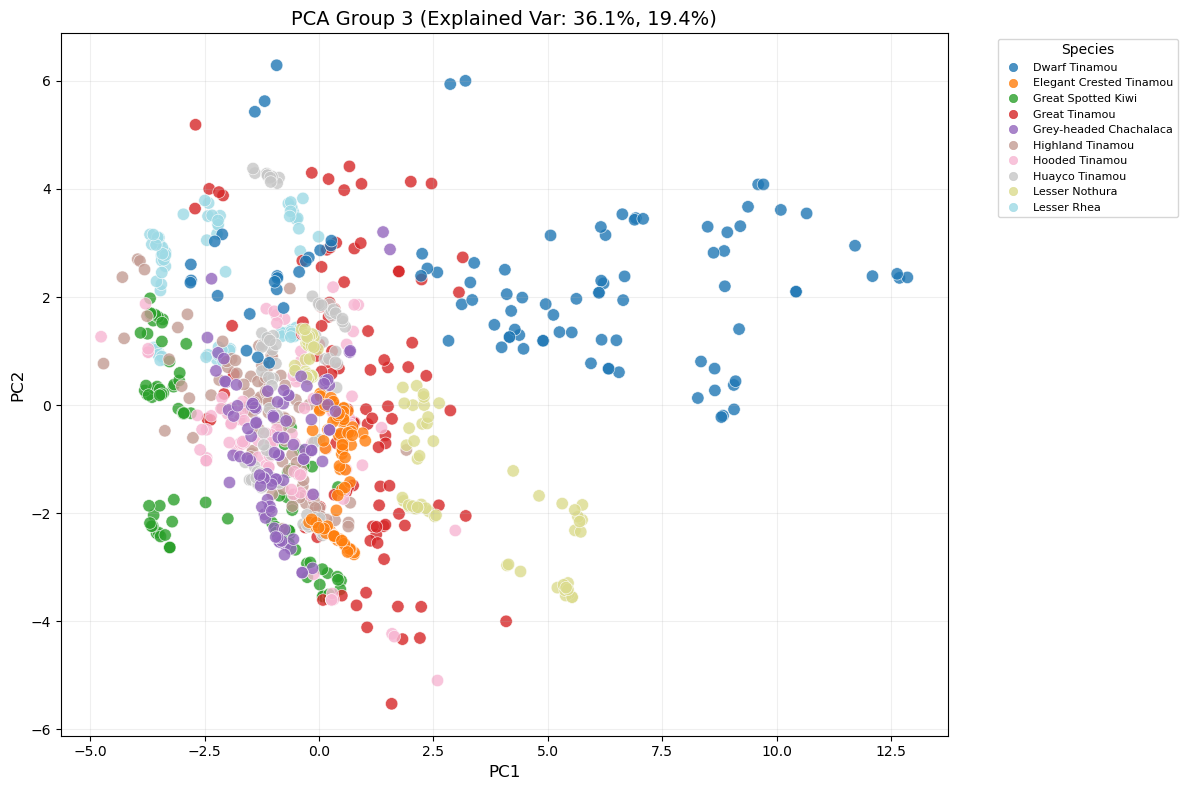


📊 PCA - Group 4: 10 species


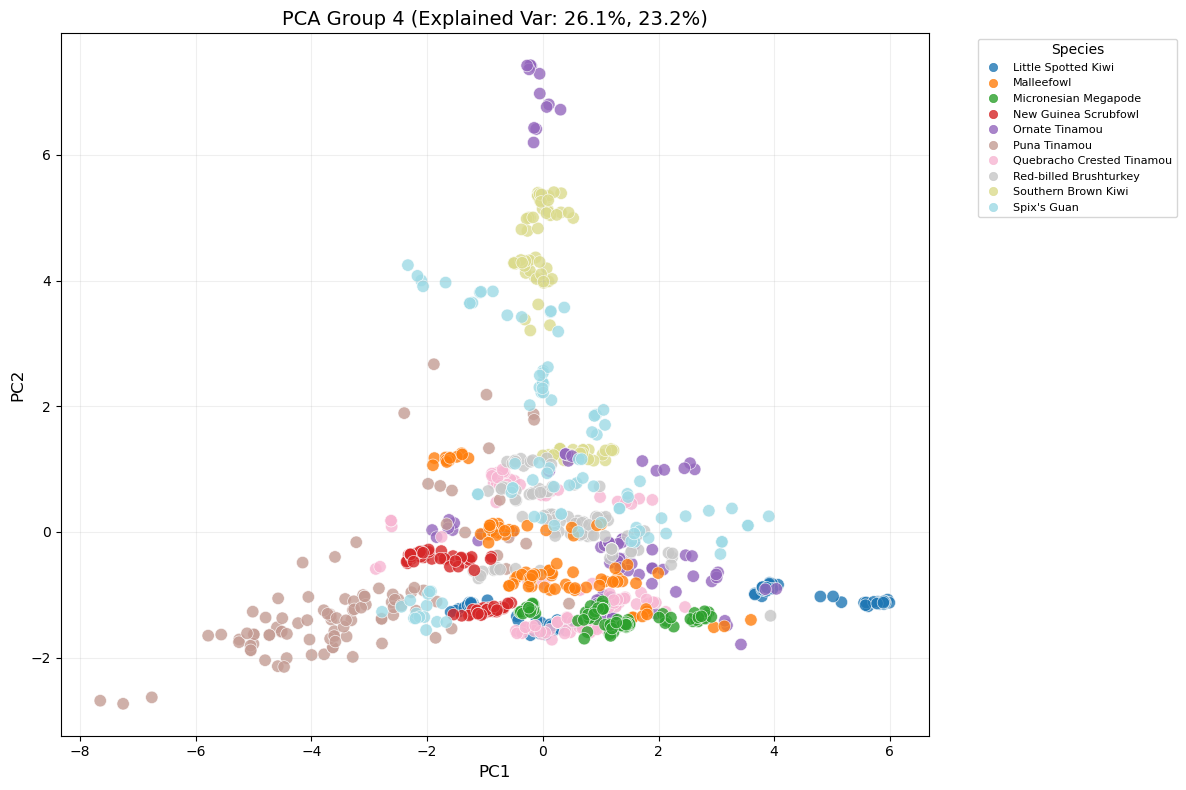


📊 PCA - Group 5: 10 species


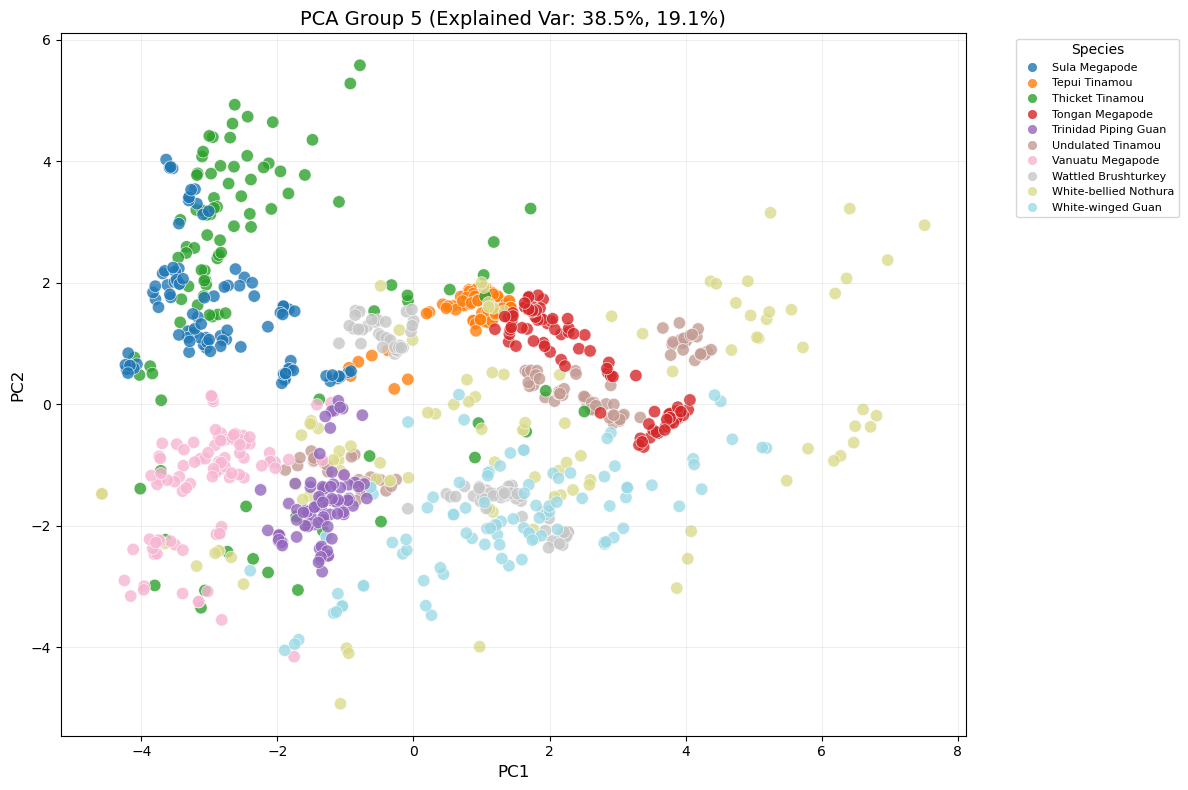


📊 t-SNE - Group 1: 10 species


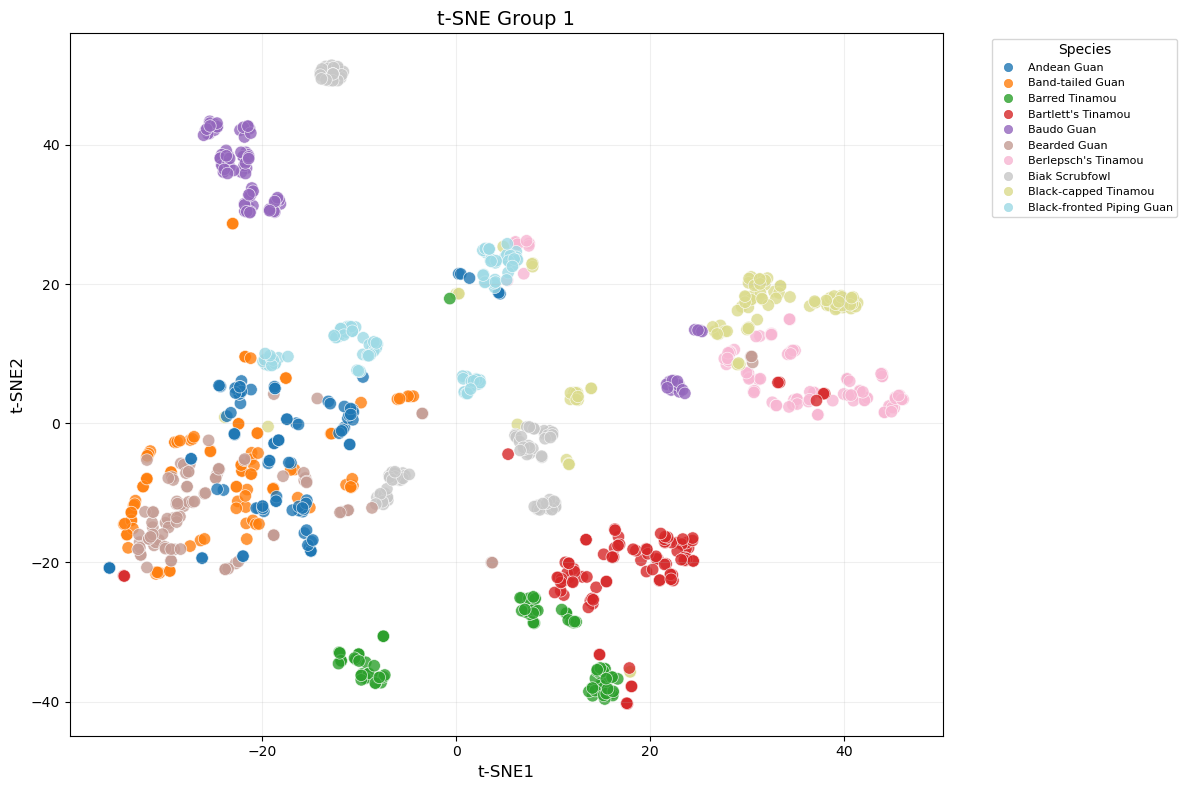


📊 t-SNE - Group 2: 10 species


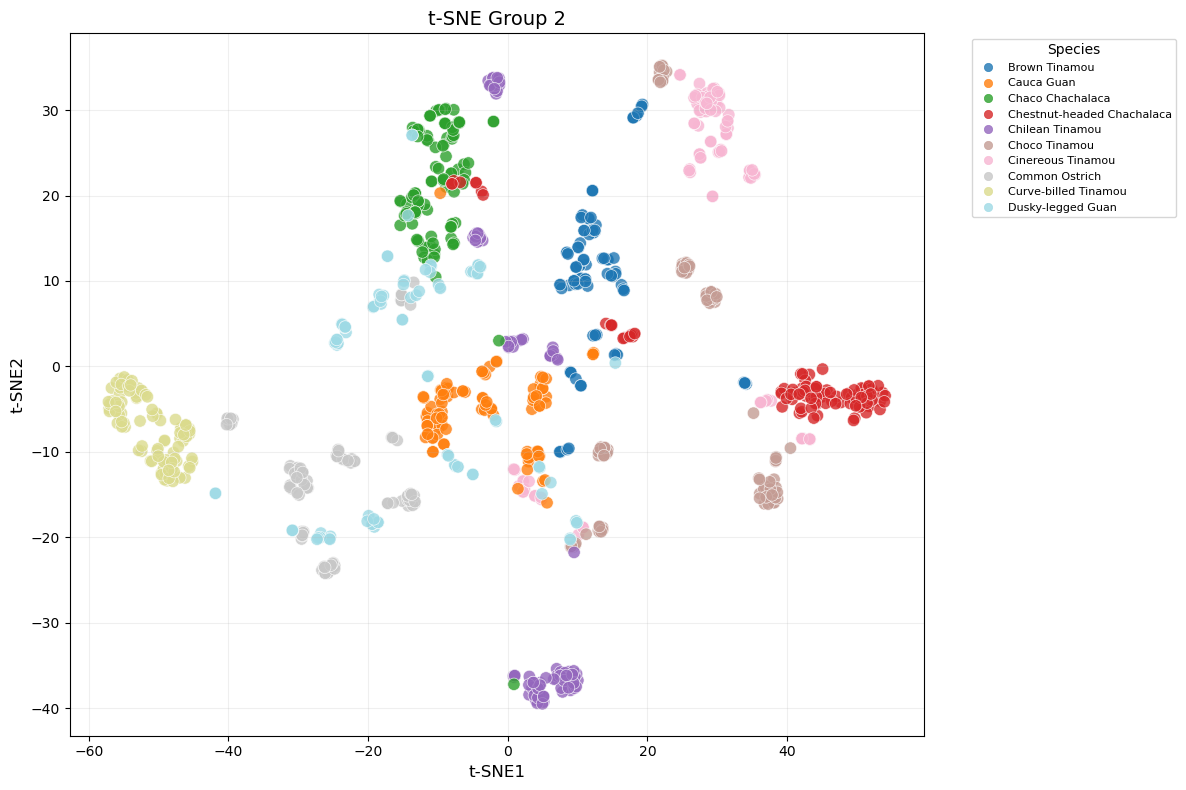


📊 t-SNE - Group 3: 10 species


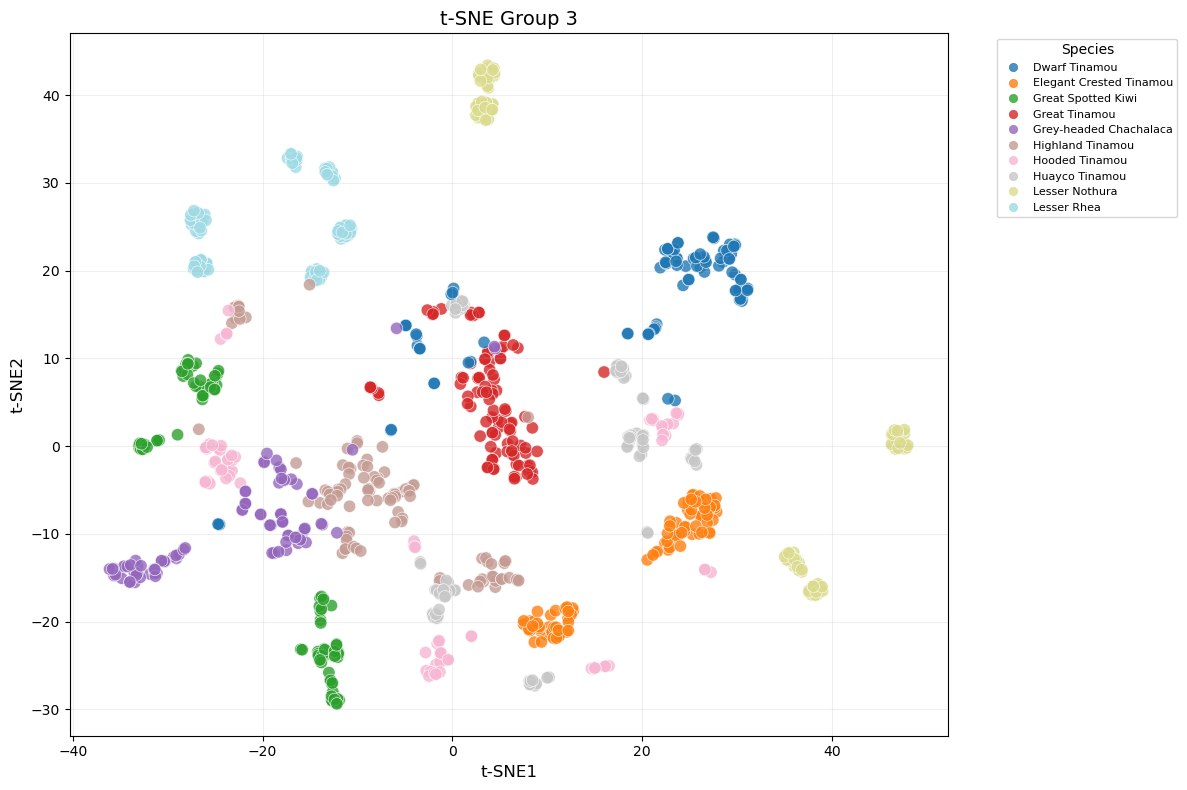


📊 t-SNE - Group 4: 10 species


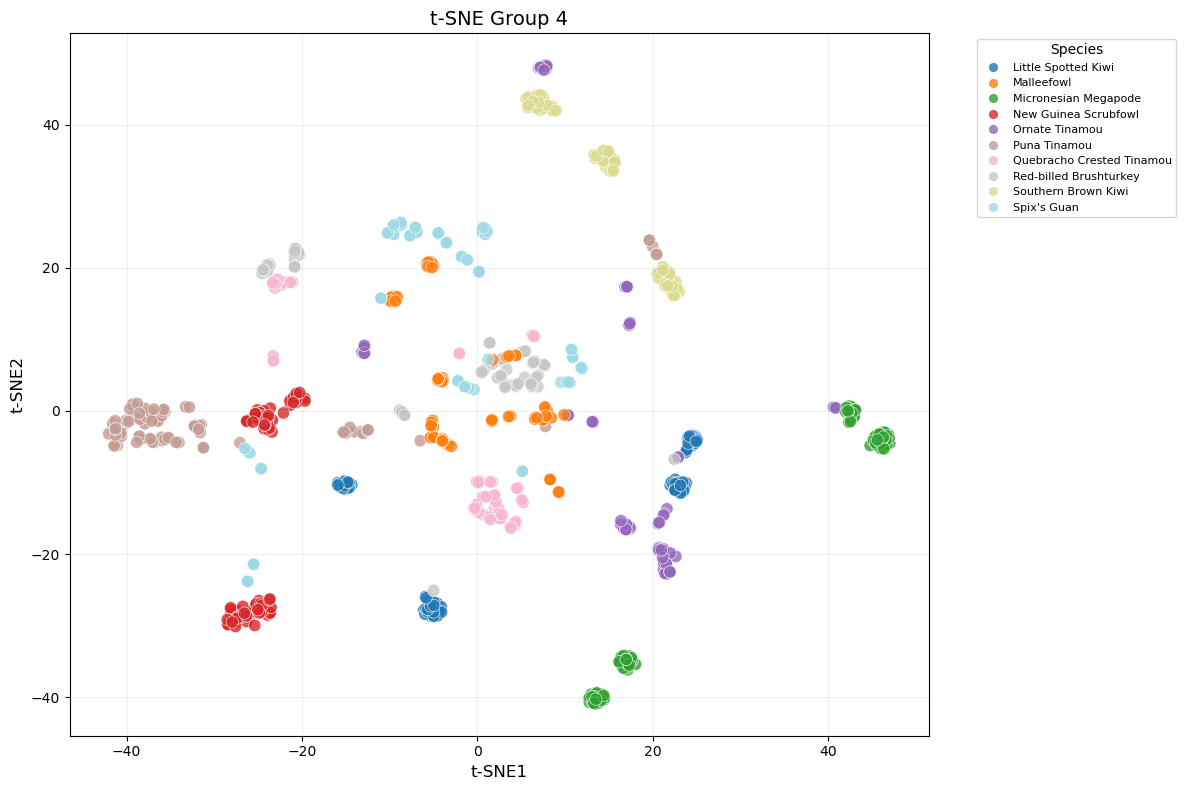


📊 t-SNE - Group 5: 10 species


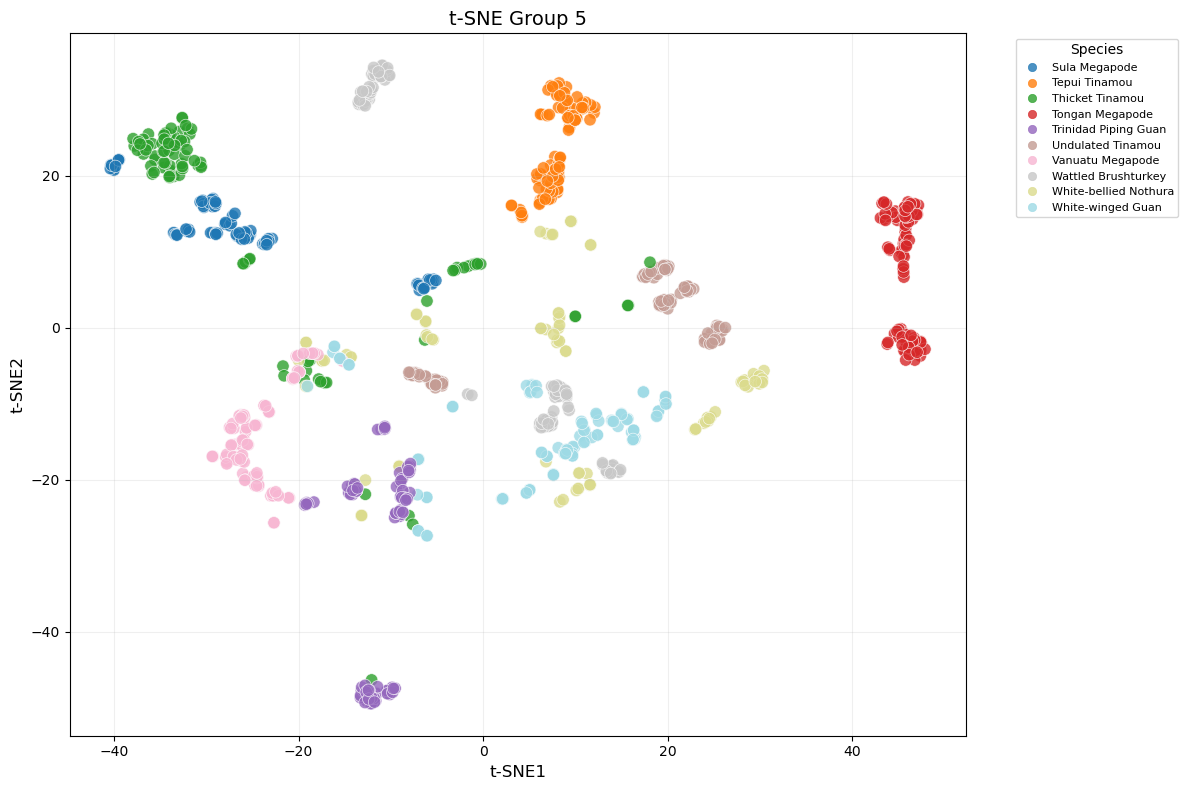


💾 Saved selected features to /Users/mariaprosgaznares/Desktop/Birdify/data/features/selected_feature_TOP50

🎉 Feature analysis completed successfully!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import (SelectKBest, mutual_info_classif, 
                                     RFE, SelectFromModel)
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import textwrap

# Configuration
BASE_DIR = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_DIR = BASE_DIR / 'data'
PROCESSED_DATA_DIR = DATA_DIR / 'processed' / 'birdcall_segments_5s_TOP50'
METADATA_PATH = DATA_DIR / 'processed' / 'birdcall_metadata_TOP50.csv'
FEATURES_DIR = DATA_DIR / 'features'
FEATURES_DIR.mkdir(parents=True, exist_ok=True)

FEATURES_PATH = FEATURES_DIR / 'birdcall_features_TOP50.csv'
OUTPUT_DIR = FEATURES_DIR / 'selected_feature_TOP50'
RANDOM_STATE = 42
N_JOBS = -1  # Use all available cores

def load_and_preprocess_features(features_path):
    """Load features and preprocess data"""
    df = pd.read_csv(features_path)
    
    # Separate features and labels
    X = df.drop(columns=['species', 'call_type', 'filename'])
    y = df['species']
    
    # Encode species names to numerical labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X_scaled, y_encoded, df, le

def comprehensive_feature_selection(X, y):
    """Multi-method feature selection pipeline"""
    print("\n🔍 Running comprehensive feature selection...")
    
    # 1. Mutual Information (Filter method)
    print("  - Mutual Information selection...")
    mi_selector = SelectKBest(mutual_info_classif, k=20)
    mi_selector.fit(X, y)
    mi_features = X.columns[mi_selector.get_support()]
    
    # 2. Recursive Feature Elimination (Wrapper method)
    print("  - Recursive Feature Elimination...")
    rfe_selector = RFE(
        estimator=SVC(kernel="linear", random_state=RANDOM_STATE),
        n_features_to_select=20,
        step=5
    )
    rfe_selector.fit(X, y)
    rfe_features = X.columns[rfe_selector.get_support()]
    
    # 3. Random Forest Importance (Embedded method)
    print("  - Random Forest Importance...")
    rf = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=N_JOBS)
    rf.fit(X, y)
    rf_selector = SelectFromModel(rf, prefit=True, threshold="1.25*mean")
    rf_features = X.columns[rf_selector.get_support()]
    
    # 4. XGBoost Importance (Embedded method)
    print("  - XGBoost Importance...")
    xgb = XGBClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=N_JOBS)
    xgb.fit(X, y)
    xgb_selector = SelectFromModel(xgb, prefit=True, threshold="1.25*mean")
    xgb_features = X.columns[xgb_selector.get_support()]
    
    # Combine results
    feature_scores = pd.DataFrame({
        'feature': X.columns,
        'MI_score': mi_selector.scores_,
        'RFE_rank': rfe_selector.ranking_,
        'RF_importance': rf.feature_importances_,
        'XGB_importance': xgb.feature_importances_
    })
    
    # Calculate consensus score
    feature_scores['consensus_score'] = (
        feature_scores['MI_score'].rank() +
        (X.shape[1] - feature_scores['RFE_rank']).rank() +
        feature_scores['RF_importance'].rank() +
        feature_scores['XGB_importance'].rank()
    )
    
    # Get top 20 features by consensus
    top_features = feature_scores.nlargest(20, 'consensus_score')['feature'].tolist()
    
    return top_features, feature_scores

def visualize_feature_space(X, y, features, method='PCA'):
    """Enhanced dimensionality reduction visualization"""
    print(f"\n📊 Visualizing feature space with {method}...")
    
    # Select top features
    X_top = X[features]
    
    if method == 'PCA':
        reducer = PCA(n_components=2, random_state=RANDOM_STATE)
        components = reducer.fit_transform(X_top)
        x_label, y_label = 'PC1', 'PC2'
        explained_var = reducer.explained_variance_ratio_
        title = f"PCA Projection (Explained Variance: {explained_var[0]:.1%}, {explained_var[1]:.1%})"
    else:  # t-SNE
        reducer = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
        components = reducer.fit_transform(X_top)
        x_label, y_label = 't-SNE1', 't-SNE2'
        title = "t-SNE Projection of Top Features"
    
    # Create interactive plot with better styling
    fig = px.scatter(
        x=components[:, 0], y=components[:, 1],
        color=y,
        hover_name=y,
        labels={'color': 'Species'},
        title=title,
        width=1000,
        height=700
    )
    
    fig.update_layout(
        xaxis_title=x_label,
        yaxis_title=y_label,
        legend_title_text='Species',
        plot_bgcolor='rgba(240,240,240,0.8)',
        paper_bgcolor='rgba(240,240,240,0.8)',
        font=dict(size=12)
    )
    
    fig.update_traces(
        marker=dict(size=10, opacity=0.7, line=dict(width=1, color='DarkSlateGrey')),
        selector=dict(mode='markers'))
    
    fig.show()
    
    return components

def plot_feature_importance(feature_scores, top_features):
    """Enhanced feature importance visualization"""
    print("\n📈 Plotting feature importance...")
    
    # Prepare data
    top_scores = feature_scores[feature_scores['feature'].isin(top_features)]
    top_scores = top_scores.sort_values('consensus_score', ascending=False)
    
    # Wrap long feature names for better display
    top_scores['feature_wrapped'] = top_scores['feature'].apply(
        lambda x: '<br>'.join(textwrap.wrap(x, width=20)))
    
    # Create figure with tabs for each metric
    fig = go.Figure()
    
    # Add traces for each metric
    metrics = ['MI_score', 'RF_importance', 'XGB_importance', 'consensus_score']
    metric_names = ['Mutual Information', 'Random Forest', 'XGBoost', 'Consensus Score']
    colors = px.colors.qualitative.Plotly[:len(metrics)]  # Use only available colors
    
    buttons = []
    for i, metric in enumerate(metrics):
        visible = [False] * len(metrics)
        visible[i] = True
        
        fig.add_trace(
            go.Bar(
                x=top_scores['feature_wrapped'],
                y=top_scores[metric],
                name=metric_names[i],
                visible=(i==0),
                marker_color=colors[i],
                text=top_scores[metric].round(3),
                textposition='outside'
            )
        )
        
        buttons.append(
            dict(label=metric_names[i],
                 method='update',
                 args=[{'visible': visible},
                       {'title': f'Feature Importance: {metric_names[i]}'}])
        )
    
    fig.update_layout(
        title='Feature Importance Metrics (Click to switch)',
        xaxis_title='Features',
        yaxis_title='Importance Score',
        height=600,
        width=1200,
        showlegend=False,
        updatemenus=[{
            'buttons': buttons,
            'direction': 'down',
            'showactive': True,
            'x': 0.1,
            'y': 1.15
        }],
        xaxis_tickangle=45,
        plot_bgcolor='white'
    )
    
    fig.show()
    
    # Additional: Small multiples plot with fixed color palette
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
    
    # Use a safe color palette
    palette = sns.color_palette("Blues", n_colors=len(metrics))
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        sns.barplot(
            x=metric, 
            y='feature_wrapped', 
            data=top_scores.sort_values(metric, ascending=False), 
            ax=ax,
            color=palette[i]
        )
        ax.set_title(metric_names[i])
        ax.set_xlabel('Score')
        ax.set_ylabel('')
    
    plt.tight_layout()
    plt.suptitle('Feature Importance Across Different Metrics', y=1.02)
    plt.show()

def plot_feature_correlation_heatmap(X, features):
    """Plot correlation heatmap of selected features"""
    print("\n🔥 Plotting feature correlation heatmap...")
    
    # Calculate correlations
    corr = X[features].corr()
    
    # Create clustermap
    plt.figure(figsize=(16, 14))
    sns.clustermap(
        corr,
        cmap='coolwarm',
        center=0,
        annot=True,
        fmt='.2f',
        annot_kws={'size': 8},
        linewidths=.5,
        figsize=(16, 14)
    )
    plt.title('Feature Correlation Heatmap (Clustered)', pad=20)
    plt.show()

def plot_feature_clustering(X, y, features):
    """Enhanced hierarchical clustering of features"""
    print("\n🌳 Plotting feature clustering...")
    
    # Calculate correlations
    corr = X[features].corr()
    
    # Calculate distance matrix
    dist_matrix = 1 - np.abs(corr)
    dist_matrix = np.nan_to_num(dist_matrix)
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(dist_matrix, 'ward')
    
    # Plot enhanced dendrogram
    plt.figure(figsize=(16, 8))
    dendrogram(
        linkage_matrix,
        labels=features,
        orientation='top',
        leaf_rotation=90,
        leaf_font_size=10,
        color_threshold=0.7 * max(linkage_matrix[:, 2])
    )
    
    plt.title('Hierarchical Clustering of Features (Ward Linkage)', fontsize=14)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Distance', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_feature_distributions(X, y, features, n_cols=4):
    """Enhanced distribution plots of top features"""
    print("\n🎻 Plotting feature distributions...")
    
    # Determine grid layout
    n_features = len(features)
    n_rows = int(np.ceil(n_features / n_cols))
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    
    # Plot each feature
    for i, feature in enumerate(features):
        ax = axes[i]
        sns.violinplot(
            x=y,
            y=X[feature],
            ax=ax,
            palette='Set3',
            inner='quartile'
        )
        ax.set_title(feature, fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('Value')
        ax.tick_params(axis='x', rotation=90)
    
    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle('Distribution of Selected Features Across Species', y=1.02)
    plt.tight_layout()
    plt.show()

def plot_pairplot_top_features(X, y, features, n_top=5):
    """Pairplot of top features"""
    print("\n📊 Plotting pairwise relationships of top features...")
    
    # Select top features
    top_features = features[:n_top]
    df = X[top_features].copy()
    df['species'] = y
    
    # Create pairplot
    g = sns.pairplot(
        df,
        hue='species',
        palette='tab20',
        plot_kws={'alpha': 0.6, 's': 30},
        diag_kind='kde',
        corner=True
    )
    
    g.fig.suptitle(f'Pairwise Relationships of Top {n_top} Features', y=1.02)
    plt.tight_layout()
    plt.show()

def plot_parallel_coordinates(X, y, features, n_top=10):
    """Parallel coordinates plot for feature analysis"""
    print("\n📉 Plotting parallel coordinates...")
    
    # Select top features and sample data if too large
    df = X[features[:n_top]].copy()
    df['species'] = y
    
    if len(df) > 1000:
        df = df.sample(1000, random_state=RANDOM_STATE)
    
    # Normalize features for better visualization
    df_norm = (df.iloc[:, :-1] - df.iloc[:, :-1].mean()) / df.iloc[:, :-1].std()
    df_norm['species'] = df['species']
    
    # Create parallel coordinates plot
    plt.figure(figsize=(16, 8))
    pd.plotting.parallel_coordinates(
        df_norm,
        'species',
        colormap='tab20',
        alpha=0.5
    )
    plt.title('Parallel Coordinates Plot of Selected Features')
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def save_selected_features(df, features, output_dir):
    """Save selected features and metadata"""
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Save selected features
    selected_df = df[['filename', 'species', 'call_type'] + features]
    selected_df.to_csv(f"{output_dir}/selected_features.csv", index=False)
    
    # Save feature importance
    feature_importance = pd.DataFrame({
        'feature': features,
        'rank': range(1, len(features)+1)
    })
    feature_importance.to_csv(f"{output_dir}/feature_importance.csv", index=False)
    
    print(f"\n💾 Saved selected features to {output_dir}")

def plot_grouped_dimensionality(X, y, features, method='PCA', n_groups=5, species_per_group=10):
    """Enhanced grouped dimensionality reduction plots"""
    unique_species = np.unique(y)
    
    # Split into groups
    species_groups = np.array_split(unique_species, n_groups)
    
    for i, group in enumerate(species_groups):
        print(f"\n📊 {method} - Group {i+1}: {len(group)} species")
        
        # Filter data for current group
        mask = y.isin(group)
        X_group = X[mask][features]
        y_group = y[mask]
        
        if method == 'PCA':
            reducer = PCA(n_components=2, random_state=RANDOM_STATE)
            components = reducer.fit_transform(X_group)
            explained_var = reducer.explained_variance_ratio_
            title = f"PCA Group {i+1} (Explained Var: {explained_var[0]:.1%}, {explained_var[1]:.1%})"
            x_label, y_label = 'PC1', 'PC2'
        else:  # t-SNE
            reducer = TSNE(n_components=2, random_state=RANDOM_STATE, 
                          perplexity=min(30, len(X_group)-1))
            components = reducer.fit_transform(X_group)
            title = f"t-SNE Group {i+1}"
            x_label, y_label = 't-SNE1', 't-SNE2'
        
        # Create plot with better styling
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(
            components[:, 0], components[:, 1],
            c=y_group.astype('category').cat.codes,
            cmap='tab20',
            s=80,
            alpha=0.8,
            edgecolors='w',
            linewidth=0.5
        )
        
        plt.title(title, fontsize=14)
        plt.xlabel(x_label, fontsize=12)
        plt.ylabel(y_label, fontsize=12)
        plt.grid(alpha=0.2)
        
        # Create legend
        handles, labels = scatter.legend_elements()
        plt.legend(
            handles, group,
            title='Species',
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            fontsize=8
        )
        
        plt.tight_layout()
        plt.show()

def main():
    print("🔬 Starting Enhanced Feature Analysis Pipeline")
    
    try:
        # 1. Load and preprocess data
        X, y_encoded, df, label_encoder = load_and_preprocess_features(FEATURES_PATH)
        y = df['species']  # Original species labels
        
        # 2. Feature selection
        top_features, feature_scores = comprehensive_feature_selection(X, y_encoded)
        print(f"\n✅ Selected top {len(top_features)} features:")
        print("\n".join(f"- {f}" for f in top_features))
        
        # 3. Enhanced Visualizations
        visualize_feature_space(X, y, top_features, method='PCA')
        visualize_feature_space(X, y, top_features, method='t-SNE')
        
        plot_feature_importance(feature_scores, top_features)
        plot_feature_correlation_heatmap(X, top_features)
        plot_feature_clustering(X, y, top_features)
        plot_feature_distributions(X, y, top_features)
        plot_pairplot_top_features(X, y, top_features)
        plot_parallel_coordinates(X, y, top_features)
        
        # 4. Grouped Dimensionality Reduction
        print("\n📊 Generating Grouped Dimensionality Reduction Plots...")
        plot_grouped_dimensionality(X, y, top_features, method='PCA')
        plot_grouped_dimensionality(X, y, top_features, method='t-SNE')
        
        # 5. Save results
        save_selected_features(df, top_features, OUTPUT_DIR)
        
        print("\n🎉 Feature analysis completed successfully!")
        
    except Exception as e:
        print(f"\n❌ Pipeline failed: {str(e)}")
        raise e

if __name__ == "__main__":
    main()

In [53]:
import joblib
import numpy as np
import os

from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

# Configuration
BASE_DIR = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_DIR = BASE_DIR / 'data'
PROCESSED_DATA_DIR = DATA_DIR / 'processed' / 'birdcall_segments_5s_113'
METADATA_PATH = DATA_DIR / 'processed' / 'birdcall_metadata_113.csv'
FEATURES_DIR = BASE_DIR / 'models' / 'KNN_model.pkl'


model = joblib.load(FEATURES_DIR)
dummy_features = np.random.rand(1, 20)  # Random features
print(model.predict(dummy_features))  # Should vary, not always the same

[39]
